## Parameterized equation of State Generators illustration notebook

First import all of the package that will be used here.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.constants import pi
from scipy.interpolate import interp1d
import TOVsolver.main as main
import TOVsolver.constant as constant
import EOSgenerators.crust_EOS as crust

### Load crust EOS and prepare interface EOS

Define constants, and load the crust EOS into this notebook, since when we solve the equation of state to TOV equation, we need full scope of the equation of state. Here, crust eos file is 'data_EOS_crust.npz', the unit is MeV/fm^3.

In [ ]:
# Convert units MeV/fm^3  -->  g/cm^3 and dyn/cm^2
c = constant.c
G = constant.G
MeVfm3_to_gcm3   = 1.7827e12
MeVfm3_to_dyncm2 = 1.6022e33

data = np.load('data_EOS_crust.npz')
P_crust = data['P_crust']
epsilon_crust = data['epsilon_crust']
data.close()

# eps_com, pres_com = crust.PolyInterpolate(epsilon_crust, P_crust)

### Defining the paramters

Defining the free prameters that we need to compute the equation of state.

After defining the parameters of the state equation, we may need to define four more functions, to compute full core equation of state.

In [ ]:
n_0 = 0.155     # saturation density
m_N = 939       # nuclear mass
m_e = 0.51      # electronic mass
m_mu = 105.6    # muon mass
hc = 197.3      # hbar*c

E_sat = -15.9   # the specific energy in symmetric nuclear matter(SNM)
K_sat = 240     # the incompressibility of SNM
Q_sat = -100    # the skewness of SNM
E_sym = 31.7    # symmetry energy
L_sym = 30      # the slope of the symmetry energy
K_sym = -100    # the curvature of the symmetry energy
Q_sym = 200     # the skewness of the symmetry energy

### Defining function

Solving the x-delta relationship.

In [ ]:
def func_x_delta(E_sym, L_sym, K_sym, Q_sym):

    # Solving the electric neutral equation
    # n_p = n_e + n_mu
    # 
    # It is important to note that when the chemical potential difference between neutrons and protons is less than the rest mass energy of muons, 
    # muons do not appear, i.e., nµ = 0; 
    # only when the chemical potential difference between neutrons and protons increases to exceed the rest mass of muons 
    # do we need to consider their contribution.
    # 
    # When writing code, we first solve equation 'n_p = n_e', then make a judgment. 
    # If muons does not appear, we directly record the result; 
    # if mu should appear, we then re-solve equation 'n_p = n_e + n_mu' and record the result again.
    # 
    # The chemical potential of electrons and muons is 
    # mu_e = mu_mu = mu_n - mu_p = 4*delta*e_sym


    # Default N is set to 200
    N = 200
    delta1 = np.zeros(N)
    x_list = np.linspace(-1 / 3, 7 / 3, N)
    # x = (n-n_0)/(3*n_0)
    for i, x1 in enumerate(x_list):

        # Symmetrical energy
        e_sym_val = E_sym + L_sym * x1 + 0.5 * K_sym * x1 ** 2 + 1 / 6 * Q_sym * x1 ** 3

        # electron number density/fm^(-3)
        n_e = lambda delta0: (16 * delta0 ** 2 * e_sym_val ** 2 - m_e ** 2) ** (3 / 2) / (3 * pi ** 2 * hc ** 3) if (16 * delta0 ** 2 * e_sym_val ** 2 - m_e ** 2) >= 0 else 0
        
        # Proton number density/fm^(-3)
        n_p = lambda delta0: (1 - delta0) / 2 * (3 * x1 + 1) * n_0

        # Define equation
        def equation(delta0):
            return n_e(delta0) - n_p(delta0)

        # Solving equation
        solution = fsolve(equation, 0.5, maxfev=1000)
        if np.isfinite(solution[0]):
            delta0_value = solution[0]
        else:
            delta0_value = 0  # If the solution fails, set a default value

        delta1[i] = delta0_value

        # Calculate the electron number density again

        n_e_val = n_e(delta0_value)

        # Electronic Fermi wave vector/fm^(-1)
        k_F = (3 * pi ** 2 * n_e_val) ** (1 / 3)

        # Electronic chemical potential/MeV
        mu_e = np.sqrt((k_F * hc) ** 2 + m_e ** 2)

        # Determine whether the muon is generated

        # No muon generated
        if mu_e < m_mu:
            pass
        
        # the muon is generated
        else:
            # muon number density
            n_mu = lambda delta0: (16 * delta0 ** 2 * e_sym_val ** 2 - m_mu ** 2) ** (3 / 2) / (3 * pi ** 2 * (hc) ** 3) if (16 * delta0 ** 2 * e_sym_val ** 2 - m_mu ** 2) >= 0 else 0

            def equation_with_mu(delta0):
                return n_p(delta0) - n_e(delta0) - n_mu(delta0)

            # Solve a new equation
            solution = fsolve(equation_with_mu, 0.5, maxfev=1000)
            if np.isfinite(solution[0]):
                delta0_value = solution[0]
            else:
                delta0_value = 0  # If the solution fails, set a default value

            delta1[i] = delta0_value

            # Recalculate the electronic chemical potential
            n_e_val = n_e(delta0_value)
            k_F = (3 * pi ** 2 * n_e_val) ** (1 / 3)
            mu_e = np.sqrt((k_F * hc) ** 2 + m_e ** 2)

    # Transpose x_list
    x1 = x_list.T

    # Traverse x_list
    for j in range(len(x_list)):
        if x1[j] > 0:
            if delta1[j] > 0.9999:
                break
    delta1[j + 1:] = 1

    # Transpose delta1 and take the real part (if delta1 is complex)
    delta1 = np.real(delta1.T)

    return x1, delta1

### Defining function

Obtain the core EOS.

In [ ]:
def func_EOS_core(E_sat,K_sat,Q_sat,E_sym,L_sym,K_sym,Q_sym,x1,delta1):

    # Obtain the core state equation
    # 
    # energy density
    # epsilon_b = n_0(3x + 1)(m_N + E/A)
    # epsilon_l = m_e^4/(8*np.pi^2*hc^3) * ( t_l*np.sqrt(1 + t_l^2)*(1 + 2 * t_l^2) - np.log(t_l + np.sqrt(1 + t_l^2)) )
    # where t_l = k_F_l / m_l * hc, l = e, mu
    # 
    # pressure
    # P_b = n_b^2 * d(epsilon_b/n_b)/dn_b = n_b * d(epsilon_b)/dn_b - epsilon_b
    # P_l = n_l^2 * d(epsilon_l/n_l)/dn_l = n_l * d(epsilon_l)/dn_l - epsilon_l

    # energy density
    # Baryon energy density
    e_sat = E_sat + 1/2 * K_sat * x1 ** 2 + 1/6 * Q_sat * x1 ** 3  # Symmetric nuclear matter with energy per nucleus
    e_sym = E_sym + L_sym * x1 + 1/2 * K_sym * x1 ** 2 + 1/6 * Q_sym * x1 ** 3  # Symmetrical energy coefficient
    varepsilon = e_sat + e_sym * delta1 ** 2  # Energy per particle
    epsilon_b = n_0 * (3 * x1 + 1) * (m_N + varepsilon)  # Baryon energy density

    # Electronic energy density
    term1 = np.maximum( 1e-10, (16 * delta1 ** 2 * e_sym ** 2 - m_e ** 2) )
    n_e = term1 ** (3 / 2) / (3 * np.pi ** 2 * hc ** 3)  # Electronic number density
    k_Fe = (3 * np.pi ** 2 * n_e) ** (1 / 3)  # Electronic Fermi wave vector
    t_e = k_Fe / m_e * hc
    epsilon_e = m_e ** 4 / (8 * np.pi ** 2 * hc ** 3) * (t_e * np.sqrt(1 + t_e ** 2) * (1 + 2 * t_e ** 2) - np.log(t_e + np.sqrt(1 + t_e ** 2)))  # Electronic energy density

    # Calculate the electronic chemical potential for later judgment
    mu_e = np.sqrt(np.maximum(0, (k_Fe * hc) ** 2 + m_e ** 2))

    # muon energy density
    term2 = np.maximum( 1e-10, (16 * delta1 ** 2 * e_sym ** 2 - m_mu ** 2) )
    n_mu = term2 ** (3 / 2) / (3 * np.pi ** 2 * hc ** 3)  # muon number density
    n_mu = n_mu * (mu_e >= m_mu)
    k_Fmu = (3 * np.pi ** 2 * n_mu) ** (1 / 3)  # muon Fermi wave vector
    t_mu = k_Fmu / m_mu * hc
    epsilon_mu = m_mu ** 4 / (8 * np.pi ** 2 * hc ** 3) * (t_mu * np.sqrt(1 + t_mu ** 2) * (1 + 2 * t_mu ** 2) - np.log(t_mu + np.sqrt(1 + t_mu ** 2)))  # muon energy density

    # Sum of energy density
    epsilon_l = epsilon_e + epsilon_mu  # Lepton energy density
    epsilon = epsilon_b + epsilon_l  # Total energy density

    # Calculate De_sym, D2e_sym, Ddelta, num, den, Dnum, Dden, D2delta
    De_sym = L_sym + K_sym * x1 + 1/2 * Q_sym * x1 ** 2
    D2e_sym = K_sym + Q_sym * x1
    num = 3 * (1 - delta1) * n_0 * np.pi ** 2 * hc ** 3 - 32 * (np.maximum(0, term1 ** 0.5 + term2 ** 0.5 * (mu_e >= m_mu)) * delta1 ** 2 * e_sym * De_sym)
    den = (3 * x1 + 1)     * n_0 * np.pi ** 2 * hc ** 3 + 32 * (np.maximum(0, term1 ** 0.5 + term2 ** 0.5 * (mu_e >= m_mu)) * delta1 * e_sym ** 2)
    Ddelta = np.where(den != 0, num / den, 0)

#     Dnum = -Ddelta * 3 * n_0 * np.pi ** 2 * hc ** 3 - 32 * (
#             np.maximum(0, (8 * (term1 ** (-0.5) + term2 ** (-0.5) * (mu_e >= m_mu))
#                            * (2 * delta1 * Ddelta * e_sym ** 2 + 2 * delta1 ** 2 * e_sym * De_sym)) * delta1 ** 2 * e_sym * De_sym)
#             + np.maximum(0, (term1 ** 0.5 + term2 ** 0.5 * (mu_e >= m_mu)) * (2 * delta1 * Ddelta * e_sym * De_sym + delta1 ** 2 * De_sym ** 2 + delta1 ** 2 * e_sym * D2e_sym)))
#     Dden = 3 * n_0 * np.pi ** 2 * hc ** 3 + 32 * (
#             np.maximum(0, (8 * (term1 ** (-0.5) + term2 ** (-0.5) * (mu_e >= m_mu))
#                            * (2 * delta1 * Ddelta * e_sym ** 2 + 2 * delta1 ** 2 * e_sym * De_sym)) * delta1 * e_sym ** 2)
#             + np.maximum(0, (term1 ** 0.5 + term2 ** 0.5 * (mu_e >= m_mu)) * (Ddelta * e_sym ** 2 + delta1 * 2 * e_sym * De_sym)))
#     D2delta = np.where(den != 0, (Dnum * den - num * Dden) / den ** 2, 0)

    # pressure
    # Baryonic pressure
    P_b = n_0 / 3 * (3 * x1 + 1) ** 2 * ((K_sat * x1 + 0.5 * Q_sat * x1 ** 2) + delta1 ** 2 * (L_sym + K_sym * x1 + 0.5 * Q_sym * x1 ** 2) + 2 * e_sym * delta1 * Ddelta)

    # Calculate electronic pressure
    P_e = n_e * mu_e - epsilon_e

    # Calculate the chemical potential of muon
    mu_mu = np.sqrt((k_Fmu * hc) ** 2 + m_mu ** 2) * (mu_e >= m_mu)

    # Calculate muon pressure
    P_mu = n_mu * mu_mu - epsilon_mu

    # Sum of pressure
    P_l = P_e + P_mu  # Lepton pressure
    P = P_b + P_l  # Total pressure

    # Extract the real part and process the array
    P[0] = 0
    P_core = np.real(P)
    epsilon_core = np.real(epsilon)

    return P_core, epsilon_core

### Defining function

Solving the phase transition point

In [ ]:
def func_transition(K_sat, Q_sat, E_sym, L_sym, K_sym, Q_sym, x1, delta1):

    # Solving the equation satisfied by the phase transition density
    # K_mu = n^2*D2e_sat + 2*n*De_sat + delta2^2*( n^2*D2e_sym + 2*n*De_sym - 2*e_sym^(-1)*(n*De_sym^2 )
    # where De_sat = de_sat/dn, D2e_sat = d^2e_sat/dn^2, De_sym = de_sym/dn, D2e_sym = d^2e_sym/dn^2
    # After obtaining the phase transition density n_t, 
    # the corresponding phase transition pressure can be obtained through the pressure calculation formula.

    n = np.linspace(0.05, 0.2, 1000)

    e_sym   =  E_sym + L_sym * ((n - n_0) / (3 * n_0)) + 1/2 * K_sym * ((n - n_0) / (3 * n_0))**2 + (1/6) * Q_sym * ((n - n_0) / (3 * n_0))**3
    De_sat  = (        K_sat * ((n - n_0) / (3 * n_0)) + 1/2 * Q_sat * ((n - n_0) / (3 * n_0))**2) * (3 * n_0)**(-1)
    D2e_sat = (        K_sat                           +       Q_sat * ((n - n_0) / (3 * n_0))   ) * (3 * n_0)**(-2)
    De_sym  = (L_sym + K_sym * ((n - n_0) / (3 * n_0)) + 1/2 * Q_sym * ((n - n_0) / (3 * n_0))**2) * (3 * n_0)**(-1)
    D2e_sym = (        K_sym                           +       Q_sym * ((n - n_0) / (3 * n_0))   ) * (3 * n_0)**(-2)
    delta2 = interp1d( n_0 * (3 * x1 + 1), delta1, kind='cubic' )(n)

    K_mu = n**2 * D2e_sat + 2 * n * De_sat + delta2**2 * ( n**2 * D2e_sym + 2 * n * De_sym - 2 * e_sym**(-1) * (n * De_sym)**2 )

    K_min = np.min(np.abs(K_mu))
    index = np.argmin(np.abs(K_mu))

    if K_min < 1:
        n_t = n[index]
    else:
        n_t = np.nan

    # Phase transition point x_t
    x_t = (n_t / n_0 - 1) / 3

    # Interpolation delta_t
    delta_t = interp1d(x1, delta1, kind='cubic')(x_t)

    # energy density 
    # Baryon energy density
    e_sym = E_sym + L_sym * x_t + 1/2 * K_sym * x_t**2 + (1/6) * Q_sym * x_t**3  # Symmetrical energy coefficient
    # Electronic energy density
    term1 = np.maximum(0, (16 * delta_t ** 2 * e_sym ** 2 - m_e ** 2))
    n_e = term1**(3/2) / (3 * np.pi**2 * hc**3)  # Electronic number density
    k_Fe = (3 * np.pi**2 * n_e)**(1/3)  # Electronic Fermi wave vector
    t_e = k_Fe / m_e * hc
    epsilon_e = m_e**4 / (8 * np.pi**2 * hc**3) * (t_e * np.sqrt(1 + t_e**2) * (1 + 2 * t_e**2) - np.log(t_e + np.sqrt(1 + t_e**2)))  # Electronic energy density
    # Calculate the electronic chemical potential for later judgment
    mu_e = np.sqrt((k_Fe * hc)**2 + m_e**2)  # Electronic chemical potential
    # Muon energy density
    term2 = np.maximum(0, (16 * delta_t ** 2 * e_sym ** 2 - m_mu ** 2))
    n_mu = term2**(3/2) / (3 * np.pi**2 * hc**3)  # muon number density
    n_mu = n_mu * (mu_e >= m_mu)
    k_Fmu = (3 * np.pi**2 * n_mu)**(1/3)  # Muon fermionic wave vector
    t_mu = k_Fmu / m_mu * hc
    epsilon_mu = m_mu**4 / (8 * np.pi**2 * hc**3) * (t_mu * np.sqrt(1 + t_mu**2) * (1 + 2 * t_mu**2) - np.log(t_mu + np.sqrt(1 + t_mu**2)))  # Muon energy density

    # delta
    De_sym = L_sym + K_sym * x_t + 1/2 * Q_sym * x_t**2
    Ddelta = (3 * (1 - delta_t) * n_0 * np.pi**2 * hc**3 - 32 * (term1**(1/2) + term2**(1/2) * (mu_e >= m_mu)) * delta_t**2 * e_sym * De_sym) \
             / (  (3 * x_t + 1) * n_0 * np.pi**2 * hc**3 + 32 * (term1**(1/2) + term2**(1/2) * (mu_e >= m_mu)) * delta_t * e_sym**2  )

    # pressure
    # Baryonic pressure
    P_b = n_0 / 3 * (3 * x_t + 1)**2 * ( (K_sat * x_t + 1/2 * Q_sat * x_t**2) + delta_t**2 * (L_sym + K_sym * x_t + 1/2 * Q_sym * x_t**2) + 2 * e_sym * delta_t * Ddelta )
    # Electronic pressure
    P_e = n_e * mu_e - epsilon_e  # Electronic pressure
    # Muon pressure
    mu_mu = np.sqrt((k_Fmu * hc)**2 + m_mu**2)  # Muon chemical potential
    mu_mu = mu_mu * (mu_e >= m_mu)
    P_mu = n_mu * mu_mu - epsilon_mu  # Muon pressure
    # Sum of pressure
    P_l = P_e + P_mu  # Lepton pressure
    P = P_b + P_l  # Total pressure
    P_t = P.real

    return n_t, P_t

### Defining function

Splicing the core EOS and crust EOS

In [ ]:
def func_EOS_crust(P_t, P_core, epsilon_core, P_crust, epsilon_crust):

    # Using Crust EOS and Phase transition pressure P_t, concatenate Core EOS to obtain the total EOS

    # Splicing condition:
    # 1. P_core = P_core(>P_t), 
    # 2. P_crust(max) < P_core(min), epsilon_crust(max) < epsilon_core(min)
    # 3. The slope of the splicing point should be less than 0.1.

    # Phase transition pressure
    P_core1 = P_core[P_core > max(P_t, 0.5)]
    epsilon_core1 = epsilon_core[-len(P_core1):]

    # Capture core EOS
    i = 0
    while i < len(P_crust):
        c1 = (P_core1[1] - P_core1[0]) / (epsilon_core1[1] - epsilon_core1[0])
        c2 = (P_crust[-i - 1] - P_crust[-i - 2]) / (epsilon_crust[-i - 1] - epsilon_crust[-i - 2])
        if P_crust[-i - 1] < P_core1[0] and epsilon_crust[-i - 1] < epsilon_core1[0] and abs(c2 - c1) < 0.1:
            break
        i += 1

    # Splicing EOS
    if i == 0:
        P = np.concatenate((P_crust, P_core1))
        epsilon = np.concatenate((epsilon_crust, epsilon_core1))
    else:
        P_crust = P_crust[:-i - 1]
        epsilon_crust = epsilon_crust[:-i - 1]

        linear_interp = interp1d(P_crust, epsilon_crust)
        P_crust_new = np.linspace(P_crust[0], P_crust[-1], 50)
        epsilon_crust_new = linear_interp(P_crust_new)

        linear_interp = interp1d(P_core1, epsilon_core1)
        P_core1_new = np.linspace(P_core1[0], P_core1[-1], 200)
        epsilon_core1_new = linear_interp(P_core1_new)

        P = np.concatenate((P_crust_new, P_core1_new))
        epsilon = np.concatenate((epsilon_crust_new, epsilon_core1_new))

    # Unit Conversion
    pres_total = P       * G / c**4 * MeVfm3_to_dyncm2
    eps_total = epsilon  * G / c**2 * MeVfm3_to_gcm3

    return pres_total, eps_total

Reference functions

In [ ]:
x1, delta1 = func_x_delta(E_sym, L_sym, K_sym, Q_sym)
P_core, epsilon_core = func_EOS_core(E_sat, K_sat, Q_sat, E_sym, L_sym, K_sym, Q_sym, x1, delta1)
n_t, P_t = func_transition(K_sat, Q_sat, E_sym, L_sym, K_sym, Q_sym, x1, delta1)
pres_total, eps_total = func_EOS_crust(P_t, P_core, epsilon_core, P_crust, epsilon_crust)

Here below is one of the possiblity, use our defined function, 'OutputMR' to compute out what the mass radius curve corresponding to this equation of state.

In [ ]:
MR = main.OutputMR('',eps_total,pres_total).T

Mass Radius file will be generated and stored as 2-d array. The first column is Radius, second one is mass

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(9,6))
ax.plot(MR[0], MR[1],lw=2)
ax.set_ylabel(r'M [$M_{\odot}$]', fontsize=16)
ax.set_xlabel('R [km]', fontsize=16)
ax.set_xlim(8., 20.)
ax.set_ylim(0,3)
ax.tick_params(top=1,right=1, which='both', direction='in', labelsize=14)
ax.tick_params(top=1,right=1, which='both', direction='in', labelsize=14)
fig.tight_layout()
plt.show()

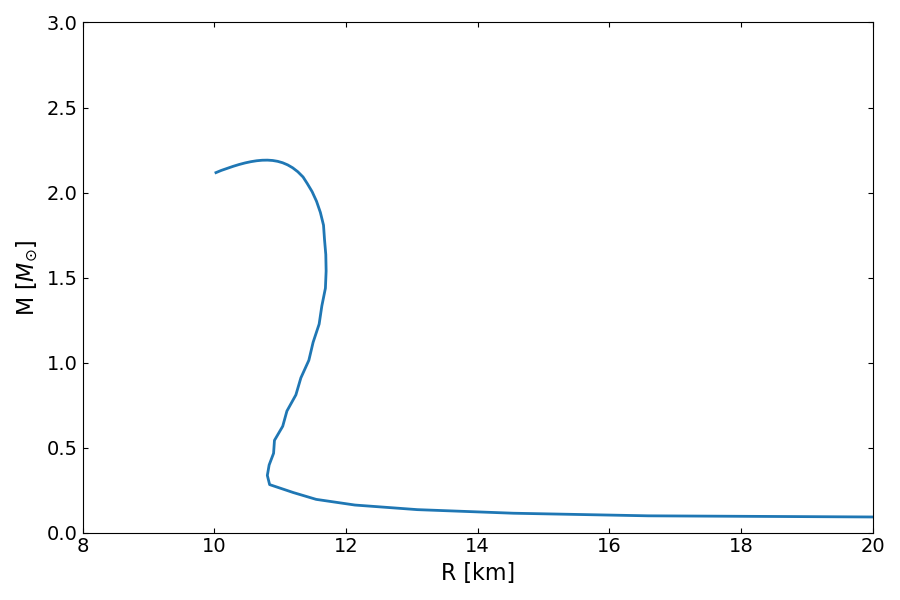